In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

try:
    os.chdir(os.path.dirname(os.path.realpath(__file__)))
except:
    pass

refineddatafolder='../Data/2-refined-data/'

def geodataframefromcsvfile(filelocation:str) -> gpd.GeoDataFrame:
    return pd.read_csv(
        filelocation,
        parse_dates=['date_occ', 'date_rptd'],
        na_filter=False,
    )
signs = pd.read_csv(
        refineddatafolder + 'refined-sign-data.csv',
        parse_dates=['last_seen_at'],
        na_filter=False,
    )
roadfeatures = pd.read_csv(
        refineddatafolder + 'refined-road-data.csv',
        parse_dates=['last_seen_at'],
        na_filter=False,
    )
collisions = pd.read_csv(
        refineddatafolder + 'refined-collision-data.csv',
        parse_dates=['date_occ', 'date_rptd'],
        na_filter=False,
    )

In [2]:
nearbycouncils=[
        'GREATER WILSHIRE NC',
        'CENTRAL HOLLYWOOD NC',
        'HOLLYWOOD STUDIO DISTRICT NC',
        'MID CITY WEST CC',
        'OLYMPIC PARK NC',
        'P.I.C.O. NC',
        'WILSHIRE CENTER - KOREATOWN NC'
    ]

relevantmocodes = {
    '3003': 'Veh vs Ped',
    '3008': 'Veh vs Bike',
    '3016': 'Bike vs Veh',
    '3501': 'Ped Actions'
}

mocodenames = list(relevantmocodes.values())

In [3]:
yearlycollisions = collisions.groupby(collisions['date_occ'].dt.year)

<AxesSubplot:title={'center':'Pedestrian and Bike Collisions by Neighborhood Council'}>

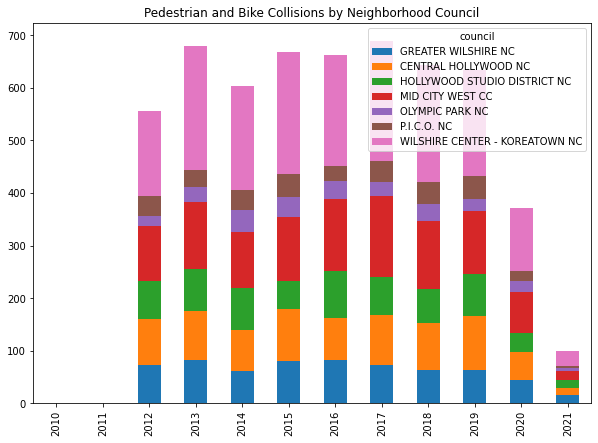

In [4]:
ncyearly = yearlycollisions['council'].value_counts().unstack()
ncyearly[nearbycouncils].plot.bar(title="Pedestrian and Bike Collisions by Neighborhood Council", stacked=True, figsize=(10,7), xlabel='')

<AxesSubplot:title={'center':'Collisions by Time of Day - Greater Wilshire'}>

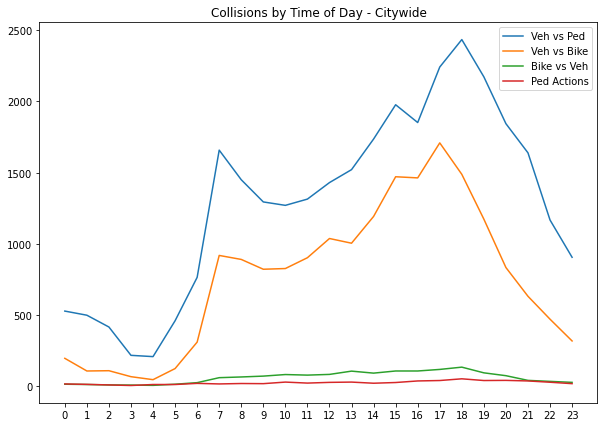

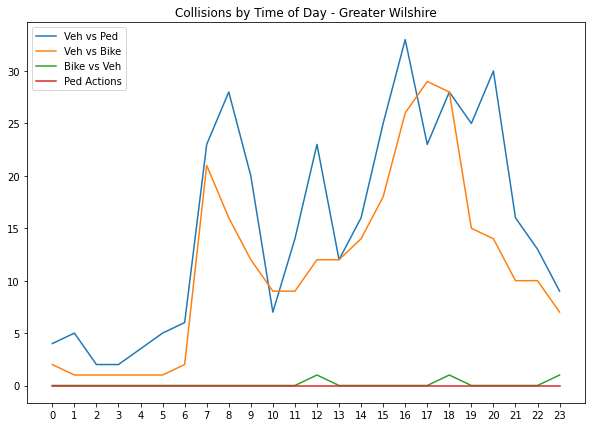

In [5]:
timeofday = collisions.groupby(collisions['date_occ'].dt.hour)
timeofday[mocodenames].sum().plot(
  title='Collisions by Time of Day - Citywide',
  xlabel='',
  xticks=range(0, 24),
  figsize=(10, 7)
)

timeofday = collisions[collisions['council'] == 'GREATER WILSHIRE NC'].groupby(collisions['date_occ'].dt.hour)
timeofday[mocodenames].sum().plot(
  title='Collisions by Time of Day - Greater Wilshire',
  xlabel='',
  xticks=range(0, 24),
  figsize=(10, 7)
)


## Statistics by cluster
Group by cluster, count each type of incident, and calculate a central GPS coordinate for each cluster.

In [6]:
wilshirecollisions = collisions[collisions.council.isin(nearbycouncils)].copy()
wilshirecollisionintersections = wilshirecollisions.groupby('cluster')
wilshireintersectioncoordinates = wilshirecollisionintersections[['longitude', 'latitude']].mean()
totalsbyintersection: pd.DataFrame = wilshirecollisionintersections[
  mocodenames
].sum()

totalsbyintersection['Total Collisions'] = totalsbyintersection.sum(axis=1)
totalsgeoframe: gpd.GeoDataFrame = totalsbyintersection.set_geometry(
  gpd.points_from_xy(wilshireintersectioncoordinates['longitude'], wilshireintersectioncoordinates['latitude'])
)


### Save intersection cluster statistics for QGIS;

In [10]:
totalsgeoframe.to_csv(refineddatafolder+'qgis-clustered-collision-counts.csv', index=False)

### Map the clusters

In [8]:
import folium

wilshiremap = folium.Map(
  location=(34.0689, -118.3386), tiles='OpenStreetMap', min_zoom=13
)

sw = wilshireintersectioncoordinates[['latitude',
  'longitude']].min().values.tolist()
ne = wilshireintersectioncoordinates[['latitude',
  'longitude']].max().values.tolist()
wilshiremap.fit_bounds([sw, ne])

colorcode = folium.StepColormap(["yellow", "pink", "red", "darkred"], vmin=1, vmax=totalsgeoframe['Total Collisions'].max())

for i, row in totalsgeoframe.iterrows():
  gpspoint = row['geometry']
  color = colorcode(row['Total Collisions'])
  label = row['Total Collisions']
  folium.Marker(
    [gpspoint.y, gpspoint.x],
    tooltip='<br />'.join([
      f'gps: {gpspoint}',
      row.to_frame().to_html()
    ]),
    icon=folium.DivIcon(
      html=f'<span style="color: {color}; background-color :white">—{label}-</span>'
    )
  ).add_to(wilshiremap)

wilshiremap
